In [5]:
## LIBRARIES ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import copy
import math

In [6]:
## INPUTS & PRESETS ##

## Model Parameters
simulations = 100 # number of simulations
sim_trials = 20 # trial runs per simulation
sim_years = 50 # years per simulation
class_count = 10 # number of adult age classes
population_initial = 70000000 # initial population size

## Demographic Options
fecund_meth = 'Calculate' # choose one: 
# 'Single Value', 'Calculate', 'Age Specific'
adult_surv_meth = 'Single Value' # choose one: 
# 'Single Value', 'Age Specific'
stoch_meth = 'Individual' # choose one: 
# 'None', 'Individual', 'General'

## Fecundity and Adult Survival
# FOR: Single Value
avg_fecundity = None # first year survival
avg_adult_survival = 0.6132 # annual adult survival
# FOR: Age Specific
avg_lst_fecundity = None # list [x,y,z...] of age-specific fecundity values
avg_lst_survival = None # list [x,y,z...] of age-specific adult survival values
# FOR: Calculate
avg_clutch = 4.26 # clutch size
avg_fledgerate = 0.48 # young fledged/total eggs
avg_fledgling_surv = 0.617 # post-fledging survival
avg_juvenile_surv = 0.6132 # juvenile survival

## Stochasticity
# FOR: General
stdev = None # how much variation exists (%)?
# FOR: Individual
# (Single Value)
sd_fecundity = None # variance, first year survival
sd_adult_surv = 0.04 # variance, annual adult survival
# (Age Specific)
sd_lst_fecundity = None # variance, list [x,y,z...] of age-specific fecundity values
sd_lst_survival = None # variance, list [x,y,z...] of age-specific adult survival values
# (Calculate)
sd_clutch = 0.975 # variance, clutch size
sd_fledgerate = 0.033 # variance, young fledged/total eggs
sd_fledgling_surv = 0.075 # post-fledging survival
sd_juvenile_surv = 0.04 # juvenile survival

## Elasticity
elast_meth = 'All' 
# 'None', 'Single', or 'All'
elast_var = None # choose one if elast_meth is 'Single':
# 'Fecundity', 'Adult Survival', 'Age Spec. Fecundity', 'Age Spec. Survival',
# 'Clutch Size', 'Fledge Rate', 'Fledgling Survival', 'Juvenile Survival'
elast_change = +10 # how much are we modifying each variable by (%)?

## Other Options
plot_trend = True # True/False, do you want to plot the results?
plot_dem = 'Control' # choose one:
# 'Control', 'Fecundity', 'Adult Survival', 'Age Spec. Fecundity', 'Age Spec. Survival', 
# 'Clutch Size', 'Fledge Rate', 'Fledgling Survival', 'Juvenile Survival'
save_file = False # True/False, do you want to save a plot?
file_name = 'StableGrowth1' # enter save file name ('plot1')

In [7]:
## FUNCTIONS ##

def envStoch(data, method, variance):
    if method == 'General':
        Dict = data
        for lab in Dict:
            if type(Dict[lab][0]) == list:
                for val in range(len(Dict[lab][0])):
                    Dict[lab][0][val] = float(np.random.normal(Dict[lab][0][val], variance/100, 1))
            else:
                Dict[lab][0] = float(np.random.normal(Dict[lab][0], variance/100, 1))
    elif method == 'Individual': 
        Dict = data
        for lab in Dict:
            if type(Dict[lab][0]) == list:
                for val in range(len(Dict[lab][0])):
                    Dict[lab][0][val] = float(np.random.normal(Dict[lab][0][val], Dict[lab][1][val], 1))
            else:
                if lab == 'Clutch Size':
                    Dict[lab][0] = np.random.normal(Dict[lab][0], Dict[lab][1], breeding_pairs).mean()
                else:
                    Dict[lab][0] = float(np.random.normal(Dict[lab][0], Dict[lab][1], 1))
    elif method == 'None':
        pass
    return data

def popGrowth(dem_dict, pop_matrix, pop_current, run_type):
    if adult_surv_meth == 'Single Value':
        Adult_Survival = [dem_dict['Adult Survival'][0]]*class_count
    elif adult_surv_meth == 'Age Specific':
        Adult_Survival = dem_dict['Age Spec. Survival'][0]
    if fecund_meth == 'Single Value':
        Fecundity = [dem_dict['Fecundity'][0]]*class_count
    elif fecund_meth == 'Age Specific':
        Fecundity = dem_dict['Age Spec. Fecundity'][0]
    elif fecund_meth == 'Calculate':
        Fecundity = [dem_dict['Clutch Size'][0]*dem_dict['Fledge Rate'][0]*\
                    dem_dict['Fledgling Survival'][0]*dem_dict['Juvenile Survival'][0]*0.5]*\
                    class_count
    for age in range(class_count):
        juveniles.append(pop_matrix[run_type,age]*Fecundity[age])
        if age < (class_count-1):
            pop_matrix[run_type+1,age+1] = round(pop_matrix[run_type,age]*Adult_Survival[age],0)
        else:
            pop_matrix[run_type+1,age] = round((pop_matrix[run_type,age]*Adult_Survival[age])+pop_matrix[run_type+1,age],0) 
            pop_matrix[run_type+1,0] = round(sum(juveniles), 0)
            pop_matrix[run_type,class_count] = round(sum(pop_matrix[run_type,0:class_count-1]),0)
            pop_matrix[run_type+1,class_count] = round(sum(pop_matrix[run_type+1,0:class_count-1]),0)
    pop_current.append(pop_matrix[run_type+1,class_count])

def createLabels(year_matrix, sim_df):
    global class_count
    global simulations
    global sim_years
    colnames_matrix = [0]*class_count
    colnames_trends = [0]*simulations
    rownames = [0]*sim_years
    for c in range(class_count):
        colnames_matrix[c] = 'Age '+str(c+1)
    for d in range(sim_years):
        rownames[d] = 'Year '+str(d+1)
    for f in range(simulations):
        colnames_trends[f] = 'Sim '+str(f+1)
    colnames_matrix.append('Total Population')
    year_matrix.columns = colnames_matrix
    year_matrix.index = rownames
    sim_df.columns = colnames_trends
    sim_df.index = rownames

def trendAnalysis(df_pop_change):
    year = [*range(1,sim_years+1)]
    lsd = []
    usd = []
    df_results = copy.copy(df_pop_change)
    df_results['Year'] = year
    df_results['Average'] = df_results.iloc[:,0:int(simulations)].mean(numeric_only=True,axis=1)
    df_results['Min'] = df_results.iloc[:,0:int(simulations)].min(axis=1,numeric_only=True)
    df_results['Max'] = df_results.iloc[:,0:int(simulations)].max(axis=1,numeric_only=True)
    df_results['StDev'] = df_results.iloc[:,0:int(simulations)].std(numeric_only=True,axis=1)
    for g in range(sim_years):
        lsd.append(df_results.Average[g]-(1.96)*(df_results.StDev[g]/math.sqrt(simulations)))
        usd.append(df_results.Average[g]+(1.96)*(df_results.StDev[g]/math.sqrt(simulations)))
    df_results['LSD'] = lsd
    df_results['USD'] = usd
    df_results = df_results.loc[:,'Year':'USD'].reset_index()
    df_results = df_results.reindex(columns=['Year','Average','Min','Max','StDev','LSD','USD'])
    return df_results

In [8]:
## MODEL SETUP ##

## Objects
runs = sim_years+sim_trials 
elast_results = []
results_labs = []
inp_means = [avg_fecundity, avg_adult_survival, avg_lst_fecundity, avg_lst_survival, avg_clutch, 
                 avg_fledgerate, avg_fledgling_surv, avg_juvenile_surv]
inp_sds = [sd_fecundity, sd_adult_surv, sd_lst_fecundity, sd_lst_survival, 
                    sd_clutch, sd_fledgerate, sd_fledgling_surv, sd_juvenile_surv]
inp_labels = ['Fecundity', 'Adult Survival', 'Age Spec. Fecundity', 'Age Spec. Survival',
                       'Clutch Size', 'Fledge Rate', 'Fledgling Survival', 'Juvenile Survival']
inp_all = [inp_means, inp_sds, inp_labels]
nested_dict = {}
results_dfs = {}
results_dict = {}
inp_dict = {}
df_trend_est = np.zeros((sim_years-1,simulations))
age_dist = np.zeros((sim_years+sim_trials-2,class_count))
df_pop_change = pd.DataFrame()

## Create Inputs Dictionary
inp_none = [n for n, val in enumerate(inp_means) if val == None]
counter = 0
for inp in inp_all:
    for none in sorted(inp_none, reverse=True):
        del inp[none]
for k in range(len(inp_labels)):
    inp_dict.update({inp_labels[k]:[inp_means[k], inp_sds[k]]})

## Create Nested Dict
nested_dict['Control'] = inp_dict
if elast_meth == 'None':
    pass
elif elast_meth == 'Single':
    if type(inp_dict[elast_var][0]) != list:
        inp_dict_copy = copy.deepcopy(inp_dict)
        x = inp_dict_copy[elast_var][0]
        new_x = x+(x*(elast_change/100))
        inp_dict_copy[elast_var][0] = new_x
        nested_dict[elast_var] = inp_dict_copy
    elif type(inp_dict[elast_var][0]) == list:
        counter = 1
        for clss in range(len(inp_dict[elast_var][0])):
            inp_dict_copy = copy.deepcopy(inp_dict)
            y = inp_dict_copy[elast_var][0][clss]
            new_y = y+(y*(elast_change/100))
            inp_dict_copy[elast_var][0][clss] = new_y
            nested_dict[elast_var+' '+str(counter)] = inp_dict_copy
            counter += 1    
elif elast_meth == 'All':
    for var in inp_labels:
        if type(inp_dict[var][0]) != list:
            inp_dict_copy = copy.deepcopy(inp_dict)
            x = inp_dict_copy[var][0]
            new_x = x+(x*(elast_change/100))
            inp_dict_copy[var][0] = new_x
            nested_dict[var] = inp_dict_copy
        elif type(inp_dict[var][0]) == list:
            counter = 1
            for clss in range(len(inp_dict[var][0])):
                inp_dict_copy = copy.deepcopy(inp_dict)
                y = inp_dict_copy[var][0][clss]
                new_y = y+(y*(elast_change/100))
                inp_dict_copy[var][0][clss] = new_y
                nested_dict[var+' '+str(counter)] = inp_dict_copy
                counter += 1

In [12]:
## MODEL ##

## Nested Dict Loop
if elast_meth != 'None':
    print('Elasticity ('+str(elast_change)+'%) was applied to the following parameters:')
else:
    print('Elasticity was not applied to this model.')
for Dict in nested_dict:
    inp_dict = nested_dict[Dict]
    df_trend_est = np.zeros((sim_years-1,simulations))
    df_pop_change = pd.DataFrame()
    
    ## Simulation Loop
    for sim in range(simulations):
        population_current_t = [] # reset pop_current
        t_matrix = np.zeros((sim_trials, class_count+1)) # reset trial_matrix
        population_current_t.append(population_initial) 
        t_matrix[0,0] = population_initial
    
        ## Trials Loop
        for trl in range(sim_trials-1):
            juveniles = [] # reset juveniles
            dem_dict = copy.deepcopy(inp_dict) # reset demographic data
            # set ceiling on breeding pairs
            if (population_current_t[0] < 1000):    
                breeding_pairs = int(population_current_t[trl]/2)
            else:
                breeding_pairs = 500

            ## Stochasticity
            dem_dict = envStoch(dem_dict, stoch_meth, stdev)
        
            ## Growth Loop
            popGrowth(dem_dict, t_matrix, population_current_t, trl)
            
            ## Log Age Distribution
            for clss in range(class_count):
                age_dist[trl,clss] = t_matrix[trl,clss]/t_matrix[0,:-1].sum()
        
        ## Transition
        # setup
        population_current = [] # reset pop_current
        matrix = np.zeros((sim_years,class_count+1)) # reset year_matrix
        # class ratios
        trial_result = t_matrix[class_count+1:]
        trial_result = np.delete(trial_result,-1,axis=1)
        trial_sum = trial_result[0,0:-1].sum()
        class_ratios = []
        for i in range(class_count):
            class_ratios.append(trial_result[0,i]/trial_sum)
            matrix[0,i] = round(class_ratios[i]*population_initial,0)
            matrix[0,-1] = population_initial
        population_current.append(population_initial)
        # check correction
        adj = population_initial-matrix[0,:-2].sum()
        if abs(adj)>population_initial*0.05:
            print('Warning: Pop_init correction > 5% ('+str(adj)+')')
        
        ## Years Loop
        for yr in range(sim_years-1):
            juveniles = [] # reset juveniles
            dem_dict = copy.deepcopy(inp_dict) # reset demographic data
            # set ceiling on breeding pairs
            if (population_current[0] < 1000):    
                breeding_pairs = int(population_current[yr]/2)
            else:
                breeding_pairs = 500

            ## Stochasticity
            dem_dict = envStoch(dem_dict, stoch_meth, stdev)
            
            ## Growth Loop
            popGrowth(dem_dict, matrix, population_current, yr)
            
            ## Log Age Distribution
            for clss in range(class_count):
                age_dist[yr+sim_trials-1,clss] = matrix[yr,clss]/matrix[0,:-1].sum()
        
        ## Finalize
        df_pop_change[int(sim)] = population_current
        for est in range(sim_years-1):
            if population_current[est] != 0:
                df_trend_est[est,sim] = (population_current[est+1]/population_current[est])-1
            else:
                df_trend_est[est,sim] = 0
        df_matrix = pd.DataFrame(data=matrix)
    df_trend_est = pd.DataFrame(data=df_trend_est)
    
    ## Create Axis Labels
    createLabels(df_matrix, df_pop_change)

    ## Calculate Results
    df_results = trendAnalysis(df_pop_change)
    results_dfs[Dict] = df_results
    results_dict.update({Dict:round(df_trend_est.iloc[:,0:int(simulations)].\
                                    mean(numeric_only=True,axis=1).mean()*100,3)})
        # print variables being tested
    if Dict != 'Control':
        print('- '+Dict,)

Elasticity (10%) was applied to the following parameters:
- Adult Survival
- Clutch Size
- Fledge Rate
- Fledgling Survival
- Juvenile Survival


In [10]:
## TRENDS & RESULTS ##

## Calculate Trends
lsd_trend = []
usd_trend = []
if elast_meth == 'All':
    df_results = results_dfs[plot_dem]
for k in range(sim_years-1):
    if df_results.iloc[k,5] == 0:
        lsd_trend.append(0)
    else:
        lsd_trend.append((df_results.iloc[k+1,5]/df_results.iloc[k,5])-1)
    if df_results.iloc[k,6] == 0:
        usd_trend.append(0)
    else:
        usd_trend.append((df_results.iloc[k+1,6]/df_results.iloc[k,6])-1)

## Elasticity
if elast_meth == 'None':
    print('\nAnnual trend estimate: '+str(round(results_dict['Control'],3))+'%')
elif elast_meth == 'Single':
    print('\nAnnual trend estimate (for "Control"): '+str(results_dict['Control'])+'%')
    print('Annual trend estimate (for "'+elast_var+'"): '+str(results_dict[elast_var])+'%')
elif elast_meth == 'All':
    for key in results_dict:
        results_dict[key] = [results_dict[key], abs(results_dict[key])]
    control_est = abs(results_dict['Control'][0])
    maxx = 0
    minn = 100
    for key in results_dict:
        diff = abs(results_dict[key][1]-control_est)
        if diff > maxx:
            maxx = diff
            kx = key
        else:
            pass
        if diff < minn and diff > 0:
            minn = diff
            kn = key
        else:
            pass
    print('\nMost elastic variable: '+str(kx)+' (\u0394 '+str(round(maxx,3))+')')
    print('Least elastic variable: '+str(kn)+' (\u0394 '+str(round(minn,3))+')\n')
    print('Annual trend estimate (for "'+plot_dem+'"): '+str(round(results_dict[plot_dem][0],3))+'%')

## Stochasticity
if stoch_meth != 'None' and elast_meth != 'Single':
    print('Range: '+str(round((sum(lsd_trend)/len(lsd_trend))*100,3))+'% to \
          '+str(round((sum(usd_trend)/len(usd_trend))*100,3))+'%')
if stoch_meth == 'General':
    print('\nNOTE: Stochasticity ('+str(stdev)+'%) was applied to each demographic rate.')
elif stoch_meth == 'Individual':
    print('\nNOTE: User-defined stochasticity was applied to each demographic rate.')
else:
    print('\nNOTE: Stochasticity was not applied to this model.')


Most elastic variable: Adult Survival (Δ 6.082)
Least elastic variable: Clutch Size (Δ 3.697)

Annual trend estimate (for "Control"): -0.102%
Range: -0.327% to           0.073%

NOTE: User-defined stochasticity was applied to each demographic rate.


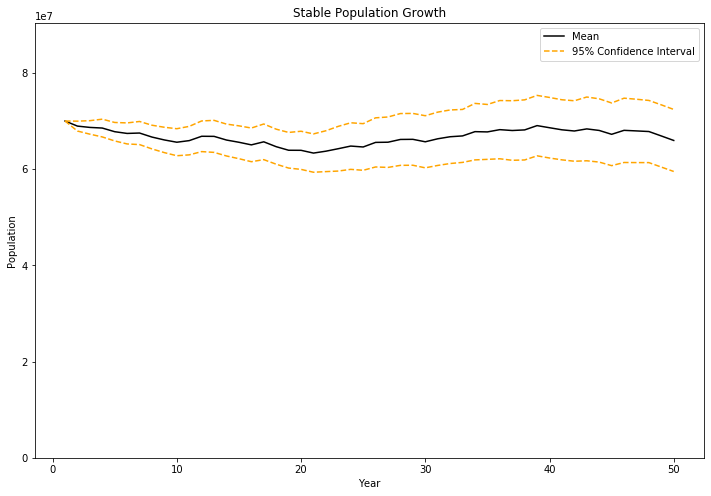

In [11]:
## VISUALIZE ##

if plot_trend:
    plt.figure(figsize=(12,8))
    plt.plot('Year','Average',c='black',label='Mean',data=df_results)
    if stoch_meth != 'None':
        plt.plot('Year','LSD','k--',c='orange',label='95% Confidence Interval',data=df_results)
        plt.plot('Year','USD','k--',c='orange',label='_nolegend_',data=df_results)
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.ylim(bottom=0, top=df_results['USD'].max()+df_results['USD'].max()*0.2) 
    plt.legend(loc='best')
    plt.title('Stable Population Growth')
    plt.show()
    if save_file:
        plt.savefig(file_name)